In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import colorcet as cc
import matplotlib.cm as colormaps
import os
plt.style.use("/n/home11/bjia/bio_publications.mplstyle")
import sys
sys.path.append("../SpikeCounter")
sys.path.append("../ephysSimsPython")
from spikecounter import utils
import pandas as pd
import seaborn as sns
import pickle
import shutil
from scipy import stats
import importlib

In [2]:
def reload_libraries():
    importlib.reload(utils)

In [3]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20221112_pde_gradI_vary_I_std/"
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures"

In [4]:
def process_stats(df, subfolder):
    df["mean_origin_pos"] = np.nan
    df["std_origin_pos"] = np.nan

    df["frac_25"] = np.nan
    df["origin_entropy"] = np.nan
    df["mean_area"] = np.nan
    df["frac_full_area"] = np.nan
    df["mean_isi"] = np.nan
    df["std_isi"] = np.nan
    df["cv_isi"] = np.nan
    df["phase_drift_rate"] = np.nan
    df["phase_variance"] = np.nan
    df["crossings_per_cycle"] = np.nan
    for idx in range(df.shape[0]):
        row = df.iloc[idx]
        measurements = np.load(os.path.join(rootdir, subfolder, row["sim_id"], "stats.npz"))
        wave_origins = measurements["all_wave_origins"]
        areas = measurements["all_areas"]
        df["mean_origin_pos"].iat[idx] = np.nanmean(wave_origins)
        df["std_origin_pos"].iat[idx] = np.nanstd(wave_origins)
        df["frac_25"].iat[idx] = np.nansum(wave_origins==24)/len(wave_origins)
        df["origin_entropy"].iat[idx] = stats.entropy(np.bincount(wave_origins[np.isfinite(wave_origins)].astype(int)),\
                                                      base=2)
        df["mean_area"].iat[idx] = np.nanmean(areas)
        df["frac_full_area"].iat[idx] = np.nansum(areas==25)/len(areas)
        df["mean_isi"].iat[idx] = np.nanmean(measurements["mean_isi"])
        df["std_isi"].iat[idx] = np.nanmean(measurements["std_isi"])
        df["cv_isi"].iat[idx] = np.nanmean(measurements["std_isi"]/measurements["mean_isi"])
        
        phase_diff = np.squeeze(measurements["phase_diff"])
        drift_rates = []
        phase_variance = []
        
        dt = 0.1
        x = np.arange(phase_diff.shape[0])*dt
        
        mod_zero_centered = np.mod(phase_diff[x>100], np.pi*2)
        mod_zero_centered[mod_zero_centered > np.pi] = mod_zero_centered[mod_zero_centered > np.pi] - np.pi*2
        mean_zero_centered = np.mean(mod_zero_centered, axis=0)
        mod_mean_centered = np.mod(mod_zero_centered - mean_zero_centered, np.pi*2)
        mod_mean_centered[mod_mean_centered > np.pi] = mod_mean_centered[mod_mean_centered > np.pi] - np.pi*2
        phase_variance.append(np.nanvar(mod_mean_centered, axis=0))
        

        for i in range(phase_diff.shape[1]):
            fit = stats.linregress(x, phase_diff[:,i])
            drift_rates.append(fit.slope)

        all_wave_timings = measurements["all_wave_timings"]
        if row["duration"] > 10000:
            all_wave_timings = all_wave_timings-40000
        all_wave_timings = all_wave_timings[all_wave_timings>100]
        if len(all_wave_timings) >= 3:

            wave_timing_indices = np.round(all_wave_timings*10).astype(int)
            per_wave_phase_diff = []
            kept_indices = [wave_timing_indices[0]]
            for i in range(1, len(wave_timing_indices)):
            #     windowed_diffs = np.mod(phase_diff[wave_timing_indices[i-1]:wave_timing_indices[i]], np.pi*2)
            #     windowed_diffs[windowed_diffs >= np.pi]
                windowed_diffs = phase_diff[kept_indices[-1]:wave_timing_indices[i]]

                if windowed_diffs.shape[0] > 10:
                    kept_indices.append(wave_timing_indices[i])
                    avg_phase_diff = np.mod(np.mean(windowed_diffs, axis=0), np.pi*2)
                    per_wave_phase_diff.append(avg_phase_diff)
            if len(per_wave_phase_diff) > 1:
                per_wave_phase_diff = np.array(per_wave_phase_diff)

                crossings = (np.diff(np.sign(np.diff(per_wave_phase_diff, axis=1)), axis=0)) !=0

                df["phase_drift_rate"].iat[idx] = np.nanmean(np.abs(drift_rates))
                df["phase_variance"].iat[idx] = np.nanmean(phase_variance)
                df["crossings_per_cycle"].iat[idx] = np.nansum(crossings)/len(kept_indices)

        
        
    df["freq"] = 1/df["mean_isi"]
    return df

In [5]:
dfs = {}

In [6]:
def load_data(rootdir, subfolder):
    hashtable = set()
    data = []
    bif_dir = os.path.join(rootdir, subfolder)
    for sim in os.listdir(bif_dir):
#         print(sim)
        sim_dir = os.path.join(bif_dir, sim)
        if os.path.isdir(sim_dir):
            try:
                with open(os.path.join(sim_dir, "params.pickle"), "rb") as pckl:
                    
                    params = pickle.load(pckl)
                    measurements = np.load(os.path.join(sim_dir, "stats.npz"))
                    if np.any(np.isfinite(measurements["mean_isi"])):
                        entry = (params["bif"], float(utils.round_rel_deviation(params["D"])),\
                                 float(utils.round_rel_deviation(params["sigma"])),\
                                 float(utils.round_rel_deviation(params["I_mean"])),\
                                 float(utils.round_rel_deviation(params["I_std"])), \
                                 float(utils.round_rel_deviation(params["I_height"])),\
                                     params["I_intercept"], params["n_y"], params["duration"])
                        h = hash(str(entry))
                        if h not in hashtable:
                            data.append(entry + (sim,))
                            hashtable.add(h)
#                     else:
#                         shutil.rmtree(sim_dir)

            except Exception as e:
#                 raise(e)
                print(e)
#                 shutil.rmtree(sim_dir)
                continue
    df = pd.DataFrame(data, columns=["bifurcation", "D", "sigma", "I_mean",\
            "I_std", "I_height", "I_intercept", "n_cells", "duration", "sim_id"])
    df = df.set_index("bifurcation")
    return df

In [7]:
subfolders = ["snic"]
bifs = ["snic"]

In [9]:
for i in range(len(subfolders)):
    dfs[bifs[i]] = process_stats(load_data(rootdir,subfolders[i]).sort_values(["D", "sigma", "I_height"]), subfolders[i])
    dfs[bifs[i]].reset_index().to_csv(os.path.join(rootdir, subfolders[i], "all_simulation_stats.csv"), index=False)

KeyboardInterrupt: 

In [159]:
subfolder = "snic"
remove_mask = dfs[subfolder]["I_mean"] > 10
for sim_id in dfs[subfolder][remove_mask]["sim_id"]:
    sim_dir = os.path.join(rootdir, subfolder, sim_id)
    shutil.rmtree(sim_dir)

In [10]:
def plot_heatmap(df, column, ax, piv_index="D", piv_column="sigma", norm="lin", cax="auto", **cbar_params):
    pv = pd.pivot_table(df, index=[piv_index], columns=[piv_column], values=column)
    Z = pv.to_numpy()
    if norm == "log":
        norm = mpl.colors.LogNorm(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    elif norm == "lin":
        norm = mpl.colors.Normalize(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    elif norm is None:
        norm = mpl.colors.Normalize(vmin=np.nanmin(Z),vmax=np.nanmax(Z))
    im = ax.pcolormesh(pv.columns, pv.index, Z,\
                norm=norm)
    ax.set_xscale("log")
    ax.set_yscale("log")
#     ax.set_xlabel(r"$\sigma$")
#     ax.set_ylabel(r"$D$")
    cbar = None
    if cax =="auto":
        cbar = plt.colorbar(im, ax=ax, **cbar_params)
    elif cax is not None:
        cbar = plt.colorbar(im, cax=cax, **cbar_params)
    return ax, im, cbar

In [14]:
dfs = {}
for idx, subfolder in enumerate(subfolders):
    dfs[bifs[idx]] = pd.read_csv(os.path.join(rootdir, subfolder, "all_simulation_stats.csv"))

In [15]:
dfs["snic"]

,bifurcation,D,sigma,I_mean,I_std,I_height,I_intercept,n_cells,duration,sim_id,...,origin_entropy,mean_area,frac_full_area,mean_isi,std_isi,cv_isi,phase_drift_rate,phase_variance,crossings_per_cycle,freq
0,snic,0.5,0.03,4.68,0.09360,0.001,12,25,10000.0,snic_20221112_111432_0e6065b3-d,...,0.021367,24.960825,0.997938,20.642544,0.128840,0.006241,2.492648e-07,0.542208,0.000000,0.048444
1,snic,0.5,0.03,4.68,0.20600,0.001,12,25,10000.0,snic_20221112_111507_68ead051-6,...,0.041408,24.930417,0.994036,19.953719,0.116298,0.005828,1.833464e-07,0.503534,0.169355,0.050116
2,snic,0.5,0.03,4.68,0.16900,0.001,12,25,10000.0,snic_20221112_111510_f765e087-4,...,0.022362,24.995652,0.997826,21.763973,0.200647,0.009219,1.061680e-07,0.534718,0.000000,0.045947
3,snic,0.5,0.03,4.68,0.03490,0.001,12,25,10000.0,snic_20221112_111412_b8dd9ab5-9,...,0.634081,22.997947,0.856263,22.313343,0.168721,0.007561,5.246284e-07,0.466982,0.132450,0.044816
4,snic,0.5,0.03,4.68,0.02870,0.001,12,25,10000.0,snic_20221112_111411_1b247e6a-f,...,0.763341,22.421053,0.797271,21.737654,0.150163,0.006908,2.688533e-06,0.454741,0.199566,0.046003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,snic,0.5,0.03,4.68,0.00720,0.611,12,25,10000.0,snic_20221112_112640_e35875ad-6,...,0.000000,24.964344,0.998379,16.228722,0.064002,0.003944,3.296994e-07,0.670357,0.000000,0.061619
500,snic,0.5,0.03,4.68,0.00591,0.611,12,25,10000.0,snic_20221112_112640_4725cf35-0,...,0.017191,24.955128,0.996795,16.053202,0.061422,0.003826,3.211148e-07,0.681866,0.000000,0.062293
501,snic,0.5,0.03,4.68,0.16900,0.611,12,25,10000.0,snic_20221112_112741_38d4a55a-8,...,0.000000,25.000000,1.000000,17.306006,0.091368,0.005280,2.699404e-07,0.653077,0.000000,0.057783
502,snic,0.5,0.03,4.68,0.02350,0.611,12,25,10000.0,snic_20221112_114405_8cc4870c-2,...,0.017191,24.961538,0.996795,16.049816,0.062172,0.003874,3.177612e-07,0.679725,0.000000,0.062306


In [16]:
dfs_single = pd.concat(dfs.values(), axis=0).set_index(["bifurcation", "I_height"])
# dfs_single.to_csv(os.path.join(figdir, "Figures", "Data", "pde_sims_gradI_sweep.csv"))

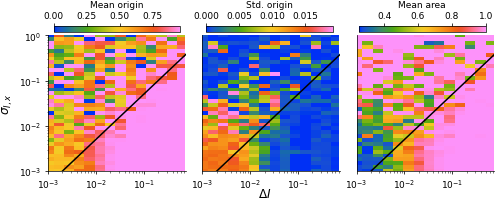

In [21]:
fig1, axes = plt.subplots(1,3,figsize=(8,2.5), gridspec_kw={"wspace":0.12})
cax1 = plt.axes([0.135, 0.9, 0.22, 0.03])
cax2 = plt.axes([0.40, 0.9, 0.22, 0.03])
cax3 = plt.axes([0.665, 0.9, 0.22, 0.03])
dfs_single["std_origin_pos"] = dfs_single["std_origin_pos"]/25
dfs_single["norm_area"] = dfs_single["mean_area"]/25
dfs_single["norm_mean_pos"] = dfs_single["mean_origin_pos"]/25

ax, im, cbar1 = plot_heatmap(dfs_single.loc["snic"], "norm_mean_pos",\
                            axes[0], piv_index="I_std", piv_column="I_height", cax=cax1, orientation="horizontal")
ax, im, cbar2 = plot_heatmap(dfs_single.loc["snic"], "std_origin_pos",\
                            axes[1], piv_index="I_std", piv_column="I_height", cax=cax2, orientation="horizontal")
ax, im, cbar3 = plot_heatmap(dfs_single.loc["snic"], "norm_area",\
                            axes[2], piv_index="I_std", piv_column="I_height", cax=cax3, orientation="horizontal")
cax1.xaxis.tick_top()

cax2.xaxis.tick_top()

cax3.xaxis.tick_top()
cax1.set_xlabel("Mean origin")
cax2.set_xlabel("Std. origin")
cax3.set_xlabel("Mean area")

cax1.xaxis.set_label_position("top")
cax2.xaxis.set_label_position("top")
cax3.xaxis.set_label_position("top")

axes[1].yaxis.set_visible(False)
axes[2].yaxis.set_visible(False)
axes[0].set_ylabel( r"$\sigma_{I,x}$", fontsize=12)
fig1.text(0.49, -0.02,r"$\Delta I$", fontsize=12)

xline = np.logspace(-3, 0)
yline = 0.5*xline
axes[0].plot(xline,yline, "k",linewidth=1.5)
axes[1].plot(xline,yline, "k",linewidth=1.5)
axes[2].plot(xline,yline, "k",linewidth=1.5)

axes[0].set_xlim(10**(-3), 0.75)
axes[1].set_xlim(10**(-3), 0.75)
axes[2].set_xlim(10**(-3), 0.75)
axes[0].set_ylim(10**(-3), 1)
axes[1].set_ylim(10**(-3), 1)
axes[2].set_ylim(10**(-3), 1)
plt.savefig(os.path.join(figdir, "Supplementary Figures/MorrisLecar_Spatial", "spatial_heterogeneity.tif"), dpi=600)